In [62]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize
import datetime

%matplotlib inline

In [2]:
# assumes periodic BCs
def metropolis_potts(init, q, boltz):
    """Returns a grid evolved one step in the q-state Potts model using the Metropolis algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # randomly choose new state
    new_state = random.randint(1,q)
    
    # select random spin from the input spin grid
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # checking the energy cost
    energy_i = potts_energy_spin(grid, [y,x])
    energy_f = potts_energy_spin(grid, [y,x], new_state)
    
    d_energy = int(energy_f - energy_i)
    
    # applying the metropolis algorithm
    if d_energy <= 0:
        grid[y,x] = new_state
        
    elif random.uniform(0,1) < boltz[str(d_energy)]:
        grid[y,x] = new_state
        
    else:
        d_energy = 0
        

    return [grid, d_energy]

In [3]:
def met_sweep(init, q, boltz):
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            # select random spin from the input spin grid
            x = random.choice(range(X))
            y = random.choice(range(Y))
            
            # randomly choose new state excluding current one
            states = [i for i in range(1, q+1)]
            states = np.delete(states, grid[y,x]-1)
            new_state = np.random.choice(states)

            # checking the energy cost
            energy_i = potts_energy_spin(grid, [y,x])
            energy_f = potts_energy_spin(grid, [y,x], new_state)

            d_energy = int(energy_f - energy_i)

            # applying the metropolis algorithm
            if d_energy <= 0:
                grid[y,x] = new_state

            elif random.uniform(0,1) < boltz[str(d_energy)]:
                grid[y,x] = new_state


    return grid

In [4]:
# assumes periodic boundary condition
def heatbath_potts(init, q, boltz):
    """Returns a grid evolved one step in the q-state Potts model using the heat-bath algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # select random spin from the input spin grid
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    
    # compute the relevant energies for the heat-bath algorithm (only nearest neighbor interactions)
    # we only want to compute the energies that are non-zero
    check = []
    check.append(grid[(y+1) % Y, x])
    check.append(grid[(y-1) % Y, x])
    check.append(grid[y % Y, (x+1) % X])
    check.append(grid[y % Y, (x-1) % X])
    check = list(set(check))
    
    
    
    # initialize the probabilities to 1 because the zero energies have boltzmann factor equal to 1
    probs = np.ones(q)
    
    # replace the appropriate elements with the boltzman factors; note that order in probs is important!
    for c in check:
        e = potts_energy_spin(grid, [y,x], c)
        probs[c-1] = boltz[str(e)]
        
    probs = np.array(probs)/np.sum(probs)   
    
    new_state = np.random.choice(range(1, q+1), p = probs)
    
    grid[y,x] = new_state
    
    return grid

    

In [5]:
def potts_energy_spin(init, spin, q = None):
    """Compute the energy of a spin on a Potts lattice"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    x = spin[1]
    y = spin[0]
    
    # allows you to change the value of the spin in question
    if q is not None:
        grid[y,x] = q
    
    energy = 0
    
    if grid[y, (x + 1) % X] == grid[y,x]:
        energy += -1

    if grid[y, (x - 1) % X] == grid[y,x]:
        energy += -1

    if grid[(y + 1) % Y, x] == grid[y,x]:
        energy += -1

    if grid[(y - 1) % Y, x] == grid[y,x]:
        energy += -1
    
    return energy
    
    
    

In [6]:
def potts_energy(init):
    """Computes the energy of a Potts grid"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            spin_energy = potts_energy_spin(init, [i,j])
            energy += spin_energy
            
    return energy/2
    
    

In [58]:
def potts_mag(init, roots):
    """Computes the magnetization of a Potts grid using a list of roots of unity"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    mag = 0
    
    for i in range(Y):
        for j in range(X):
            d_mag = roots[grid[i,j]-1]
            mag += d_mag
            
    mag = abs(mag)
            
    return mag

In [7]:
def plot_potts(grid, title = '', cmap = plt.cm.coolwarm):
    """Plot a Potts grid using a color map"""
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(grid, cmap=cmap)
    plt.colorbar()
    
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

In [8]:
random.seed(2)
init = np.random.randint(1, 11, (20, 20))
test = copy.copy(init)

T = 0.5
boltz = {'-1' : np.exp(1/T), '-2' : np.exp(2/T), '-3' : np.exp(3/T), '-4' : np.exp(4/T)}

In [34]:
energy_list = []

start = time.time()
for i in range(400*1000):
    output = heatbath_potts(test, 10, boltz)
    energy_list.append(potts_energy(output))
    test = output
    if ((i+1) % 20000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/400}; {tick-start} seconds')
    
energy_list = np.array(energy_list)/400

#np.save('potts20_heatbath1000.npy', energy_list)

Sweep 50.0; 21.649895668029785 seconds
Sweep 100.0; 48.16802978515625 seconds
Sweep 150.0; 76.37305998802185 seconds
Sweep 200.0; 104.564697265625 seconds
Sweep 250.0; 132.81783866882324 seconds
Sweep 300.0; 163.28115582466125 seconds
Sweep 350.0; 193.4354648590088 seconds
Sweep 400.0; 224.01930975914001 seconds
Sweep 450.0; 254.2023868560791 seconds
Sweep 500.0; 285.28619956970215 seconds
Sweep 550.0; 316.0580279827118 seconds
Sweep 600.0; 347.2464964389801 seconds
Sweep 650.0; 378.4478614330292 seconds
Sweep 700.0; 408.7990822792053 seconds
Sweep 750.0; 438.9583513736725 seconds
Sweep 800.0; 469.66272377967834 seconds
Sweep 850.0; 500.3239459991455 seconds
Sweep 900.0; 531.1825737953186 seconds
Sweep 950.0; 562.7519698143005 seconds
Sweep 1000.0; 593.5327272415161 seconds


In [56]:
energy_list_met = []

start = time.time()
for i in range(400*1000):
    output = metropolis_potts(test, 10, met_boltz)[0]
    energy_list_met.append(potts_energy(output))
    test = output
    if ((i+1) % 20000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/400}; {tick-start} seconds')
        
energy_list_met = np.array(energy_list_met)/400

#np.save('potts20_met1000.npy', energy_list_met)

Sweep 50.0; 28.977301120758057 seconds
Sweep 100.0; 57.517130851745605 seconds
Sweep 150.0; 85.46622490882874 seconds
Sweep 200.0; 113.76301431655884 seconds
Sweep 250.0; 142.3137559890747 seconds
Sweep 300.0; 170.98105716705322 seconds
Sweep 350.0; 199.14095091819763 seconds
Sweep 400.0; 227.5706684589386 seconds
Sweep 450.0; 256.0445303916931 seconds
Sweep 500.0; 284.6949677467346 seconds
Sweep 550.0; 313.0641734600067 seconds
Sweep 600.0; 341.5965631008148 seconds
Sweep 650.0; 369.9920566082001 seconds
Sweep 700.0; 398.62513422966003 seconds
Sweep 750.0; 427.54341173171997 seconds
Sweep 800.0; 455.74199318885803 seconds
Sweep 850.0; 484.11566281318665 seconds
Sweep 900.0; 512.5295088291168 seconds
Sweep 950.0; 540.9116101264954 seconds
Sweep 1000.0; 569.8750236034393 seconds


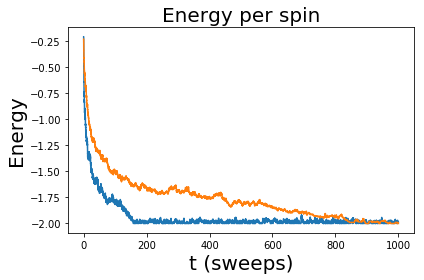

In [57]:
plt.plot(x_values, energy_list)
plt.plot(x_values,energy_list_met)
plt.title('Energy per spin', fontsize = 20)
plt.xlabel("t (sweeps)", fontsize=20)
plt.ylabel("Energy", fontsize=20)
plt.tight_layout()

In [335]:
energy_list_q3 = []

start = time.time()
for i in range(400*700):
    output3 = heatbath_potts(test3, 3, boltz)
    energy_list_q3.append(potts_energy(output3))
    test3 = output3
    if ((i+1) % 20000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/400}; {tick-start} seconds')
    
energy_list_q3 = np.array(energy_list_q3)/400

# np.save('potts20_heatbath_q3.npy', energy_list_q3)

Sweep 50.0; 21.67469596862793 seconds
Sweep 100.0; 42.98979139328003 seconds
Sweep 150.0; 64.0340723991394 seconds
Sweep 200.0; 85.33528017997742 seconds
Sweep 250.0; 106.42420077323914 seconds
Sweep 300.0; 127.53544092178345 seconds
Sweep 350.0; 148.63775300979614 seconds
Sweep 400.0; 169.72816133499146 seconds
Sweep 450.0; 191.00754570960999 seconds
Sweep 500.0; 214.37508940696716 seconds
Sweep 550.0; 238.94245600700378 seconds
Sweep 600.0; 260.24366426467896 seconds
Sweep 650.0; 281.44716024398804 seconds
Sweep 700.0; 302.8059046268463 seconds


In [73]:
x_values = np.array([i for i in range(1,625*1000+1)])/625

In [86]:
x_values = np.arange(0, 625*2000, 100)/625

In [117]:
random.seed(1)
init3 = np.random.randint(1, 4, (25, 25))
test3 = copy.copy(init3)

T = 0.8
met_boltz = {'1' : np.exp(-1/T), '2' : np.exp(-2/T), '3' : np.exp(-3/T), '4' : np.exp(-4/T)}

energy_list_metq3 = []

start = time.time()
for i in range(625*2000):
    output3 = metropolis_potts(test3, 3, met_boltz)[0]
    
    if ((i + 1) % 100) == 0:
        energy_list_metq3.append(potts_energy(output3))
        
    test3 = output3
    
    if ((i+1) % 125000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/625}; {tick-start} seconds')
        
energy_list_metq3 = np.array(energy_list_metq3)/400

# np.save('potts20_met_q3.npy', energy_list_metq3)

Sweep 200.0; 3.2324306964874268 seconds
Sweep 400.0; 6.486189603805542 seconds
Sweep 600.0; 9.755820274353027 seconds
Sweep 800.0; 12.987755298614502 seconds
Sweep 1000.0; 16.320874214172363 seconds
Sweep 1200.0; 19.6574649810791 seconds
Sweep 1400.0; 23.2003915309906 seconds
Sweep 1600.0; 26.59699845314026 seconds
Sweep 1800.0; 29.965829133987427 seconds
Sweep 2000.0; 33.26274061203003 seconds


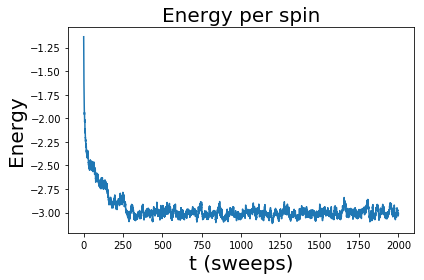

In [118]:
plt.plot(x_values, energy_list_metq3)
plt.title('Energy per spin', fontsize = 20)
plt.xlabel("t (sweeps)", fontsize=20)
plt.ylabel("Energy", fontsize=20)
plt.tight_layout()

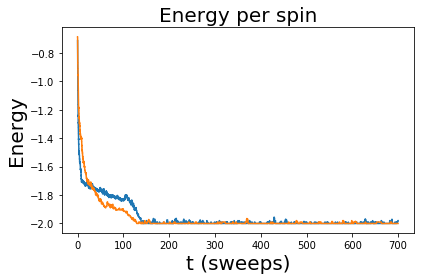

In [341]:
plt.plot(x_values, energy_list_q3)
plt.plot(x_values, energy_list_metq3)
plt.title('Energy per spin', fontsize = 20)
plt.xlabel("t (sweeps)", fontsize=20)
plt.ylabel("Energy", fontsize=20)
plt.tight_layout()

In [53]:
def round_to_3(x):
    if x != 0:
        return round(x, -int(np.floor(np.log10(abs(x)))) + 2)
    else:
        return 0

In [ ]:
# initialize to T = infinity
random.seed(1)
init20 = np.random.randint(1, 4, (25, 25))
temps = [i for i in np.arange(0.6, 1.41, 0.01)]

for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)


# initialize dictionaries to store values
energy_dict20 = {}
mag_dict20 = {}


# initialize lists to plot
eneps_list20 = np.zeros(t_points)
magps_list20 = np.zeros(t_points)
spec_heat20 = np.zeros(t_points)
mag_sus20 = np.zeros(t_points)

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 1000

# number of sweeps to average over
n = 300

# set up keys and entries for dictionary
for T in temps:
    energy_dict20[str(T)] = []
    mag_dict20[str(T)] = []

# factors for averaging
n1 = 1/(n * 20**2)
n2 = 1/(n**2 * 20**2)


# roots of unity
rou = [np.exp(2*np.pi*1j*n/3) for n in range(3)]

# running the program!
print(datetime.datetime.now().time())
start = time.time()

grid = copy.copy(init20)

for i in range(t_points):
    T = temps[i]
    met_boltz = {'1' : np.exp(-1/T), '2' : np.exp(-2/T), '3' : np.exp(-3/T), '4' : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = met_sweep(grid, 3, met_boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total = 0
    
    # dummy lists to hold the measurements
    e_all = np.zeros(n)
    m_all = np.zeros(n)
    
    # measurements to average
    for k in range(n):
        grid = met_sweep(grid, 3, met_boltz)
        energy = potts_energy(grid)             # only taking measurements every other sweep
        mag = potts_mag(grid, rou)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
        
        e_all[k] = energy
        m_all[k] = mag
    
    # storing all measurements for error purposes 
    energy_dict20[str(T)] = e_all
    mag_dict20[str(T)] = m_all
    
    # compute averages
    eneps_list20[i] = n1*e_total
    magps_list20[i] = n1*mag_total
    spec_heat20[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus20[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    if (0.599 < T < 0.601) or (0.799 < T < 0.801) or (0.999 < T < 1.001) or (1.199 < T < 1.201):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

22:11:40.206354
T = 0.6; 18.02810549736023 seconds
T = 0.8; 369.7792727947235 seconds
T = 1.0; 725.5093507766724 seconds


In [ ]:
np.save('Potts_eneps25v3.npy', eneps_list20)
np.save('Potts_spec_heat25v3.npy', spec_heat20)
np.save('Potts_magps25v3.npy', magps_list20)
np.save('Potts_magsus25v3.npy', mag_sus20)
np.save('Potts_ene_dict25v3.npy', energy_dict20)
np.save('Potts_mag_dict25v3.npy', mag_dict20)

In [ ]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list20, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat20, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, magps_list20, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus20, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetic Susceptibility", fontsize=20)